# Regression

We've been working with **classification** models, where we try to determine what something is. Now we're curious about determining a *specific* value based on an input. For example, using a neural network to predict what the temperature will be tomorrow or what the price of a car should be. For a task like this, we need something with a much more granular output. This also means that we require a new way to measure loss, as well as a new output layer activation function!. It also means our data are different. We need training data that have target scalar values, not classes.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data

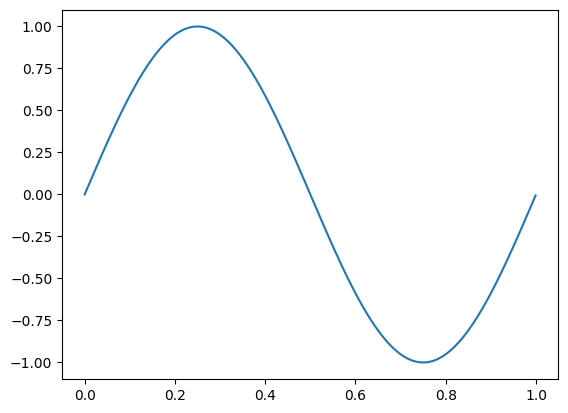

In [3]:
nnfs.init()

X, y = sine_data()

plt.plot(X, y)
plt.show()


## Linear Activation

Since we're no longer using classification labels and want to predict a scalar value, we're going to use a linear activation function for the output layer. This linear function does not modfiy its input and passes it to the output: y=x. For the backward pass, we already know the derivative of *f(x)=x* is *1*; thus, the full class for our new linear activation function is:

In [4]:
class Activation_Linear:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

This might raise a question - why do we even write some code that does nothing? We just pass inputs to outputs for the forward pass and do the same with gradients during the backward pass since, to apply the chain rile, we multiply incoming gradients by the derivatives, which is 1. We do this only for completeness and clarity to see the activation function of the output layer in the model definition code. From a computational time point of view, this adss almost nothing to the processing time, at least not enough to noticeably impact training time.

## Mean Squared Error Loss

Since we aren't working with classification labels anymore, we cannot calculate cross-entropy. Instead, we need some new methods. The two main methods for calculating error in regression are **mean squared error** (MSE) and **mean absolute error** (MAE).

With mean square error, we square the difference between the predicted and true values of single output (as the model can have multiple regression outputs) and average those squared values.

The idea is to penalize more harshly the further away we get from the intended target.

## Mean Squared Error Loss Derivative

$$
\begin{aligned}
L &= \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2 \\
\frac{\partial L}{\partial \hat{y}_i} &= \frac{\partial}{\partial \hat{y}_i}\left[\frac{1}{n}\sum_{j=1}^n (y_j - \hat{y}_j)^2\right] \\
&= \frac{2}{n}(y_i - \hat{y}_i)\cdot(-1) \\
\frac{\partial L}{\partial \hat{y}_i} &= -\frac{2}{n}(y_i - \hat{y}_i)
\end{aligned}
$$

The partial derivative equals -2, multiplied by the subtraction of the true ans predicted values, and then divided by the number of outputs to normalize the gradients, making their magnitude invariant to the number of outputs.

## Mean Squared Error (MSE) Loss Code

The code for MSE includes an implementation of the equation to calculate the sample loss from multple outputs. `axis=-1` with the mean calculation informs NumPy to calculate mean across outputs, for each sample separately. For the backward pass, we implemented the derivative equation, which results in -2 multiplied by the difference of true and predicted values, and normalized by the number of outputs. Simiarly to the other loss function implementations, we also normalize gradients by the number of samples to make them invariant to the batch size, or the number of samples in general:


In [6]:
class Loss:
    ...

class Loss_MeanSquaredError(Loss):

    def forward(self, y_pred, y_true):

        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = -2 * (y_true - dvalues) / outputs

        self.dinputs = self.dinputs / samples


## Mean Absolute Error Loss

We already calculated the partial derivative of an absolute value for the L1 regularization, which
is similar to the L1 loss. The derivative of an absolute value equals 1 if this value is greater than
0, or -1 if it’s less than 0. The derivative does not exist for a value of 0:

The code for mean absolute error is very similar to mean squared error. The forward pass includes NumPy's `np.abs()` to calculate absolute values before calculating the mean. For the backward pass, we'll use `np.sign()`, which returns 1 or -1 given the sign of the inputs and 0 if the parameter equals 0, then normalize gradients by the number of samples to make them invariant to the batch size, or the number of samples in general:

In [7]:
class Loss_MeanAbsoluteError(Loss):

    def forward(self, y_pred, y_true):

        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        return sample_losses

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples


# Accuracy in Regression

With cross-entropy, we were able to count the number of matches (situations where the prediction equals the ground truth target), and then divide it by the number of samples to measure the model's accuracy. With a regression model, we have two problems:

* the first problem is that each output neuron in the model (there might be many) is a separate output - like in a binary regression model and unlike in a classifer, where all outputs contribute toward a common prediction.

* the second probelm is that the prediction is a float value, and we can't simply check if the output value equals the ground truth one, as it most likely won't -- if it differs even slightly, the accuracy will be a 0.


A pure comparison between 192.5 and 192.49 will return False. We'd likely consider the predicted value to be correct or "close enough", given the magnitude of the numbers in consideration. There's no perfect way to show accuracy with regression. Still, it is preferable to have some accuracy metric.

For example, Keras, shows both accuracy and loss for regression models, and we'll make our own.

First, we need some "limit" value, which we'll call "precision". To calculate this precision, we'll calculate the standard deviation from the ground truth target values and then divide it by 250. This value can certainly vary depending on our goals. The larget the number we divide by, the more "strict" the accuracy metric will be. *250* is our value of choice.

In [13]:
accuracy_precision = np.std(y) / 250
# print(f"sdt {np.std(y)}")
accuracy_precision


np.float64(0.0028284271247461905)

Then we could use this precision value as a sort of "cushion allowance" for regression outputs when comparing targets and predicted values for accuracy. We perform the comparison by applying the absolute value on the difference between the ground truth values and the predictions. Then we check if the difference is smaller than our previously calculated precision:

In [ ]:
predictions = activation2.output
accuracy = np.mean(np.absolute(predictions - y) < (accuracy_precision))

## Regression Model Training



In [146]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0.,
                 weight_regularizer_l2=0.,
                 bias_regularizer_l1=0.,
                 bias_regularizer_l2=0.):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues,
                              axis=0,
                              keepdims=True)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        self.dinputs = np.dot(dvalues,
                              self.weights.T)


In [147]:
class Layer_Dropout:

    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1,
                                              self.rate,
                                              size=inputs.shape) / self.rate

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask


In [148]:
class Activation_ReLU:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs < 0] = 0


In [149]:
class Activation_Softmax:

    def forward(self, inputs):
        self.inputs = inputs

        exp_values = np.exp(inputs - np.max(inputs,
                                            axis=1,
                                            keepdims=True))
        probabilities = exp_values / np.sum(exp_values,
                                            axis=1,
                                            keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - \
                                np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian_matrix,
                                  single_dvalues)


In [150]:
class Activation_Sigmoid:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output


In [151]:
class Activation_Linear:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()


In [64]:
class Optimizer_SGD:

    def __init__(self,
                 learning_rate=1.,
                 decay=0.,
                 momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations ))

    def update_params(self, layer):
        if self.momentum:

            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums - \
                                     self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - \
                                    self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1



In [65]:
class Optimizer_Adagrad:

    def __init__(self,
                 learning_rate=1.,
                 decay=0.,
                 epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        layer.weights += -self.current_learning_rate * \
                        layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


In [66]:
class Optimzier_RMSProp:

    def __init__(self,
                 learning_rate=0.001,
                 decay=0.,
                 epsilon=1e-7,
                 rho=0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + \
                             (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + \
                           (1 - self.rho) * layer.bias_cache ** 2

        layer.weights += -self.current_learning_rate * \
                        layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


In [152]:
class Optimizer_Adam:

    def __init__(self,
                 learning_rate=0.001,
                 decay=0.,
                 epsilon=1e-7,
                 beta_1=0.9,
                 beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.bias_momentums = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * \
                                layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                                layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / \
                                     (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
                                   (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + \
                             (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
                           (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / \
                                 (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
                               (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * \
                            weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        bias_momentums_corrected / \
                        (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


In [153]:
class Loss:

    def regularization_loss(self, layer):

        regularization_loss = 0

        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                    np.sum(np.abs(layer.weights))

        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                    np.sum(layer.weights * layer.weights)

        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                np.sum(np.abs(layer.biases))

        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                np.sum(layer.biases * layer.biases)

        return regularization_loss

    def calculate(self, output, y):

        sample_losses = self.forward(output, y)

        data_loss = np.mean(sample_losses)

        return data_loss


In [154]:
class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):

        samples = len(y_pred)

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples


In [103]:
class Activation_Softmax_Loss_CategoricalCrossentropy:

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):

        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples


In [104]:
class Loss_BinaryCrossentropy(Loss):

    def forward(self, y_pred, y_true):

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        sample_losses = -(y_true * np.log(y_pred_clipped) + \
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        return sample_losses

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        outputs = len(dvalues[0])

        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        self.dinputs = -(y_true / clipped_dvalues - \
                         (1 - y_true) / (1 - clipped_dvalues)) / \
                       outputs
        self.dinputs = self.dinputs / samples

In [105]:
class Loss_MeanSquaredError(Loss):

    def forward(self, y_pred, y_true):

        sample_losses = np.mean((y_true - y_pred) ** 2,
                                axis=-1)

        return sample_losses

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples


In [106]:
class Loss_MeanAbsoluteError(Loss):

    def forward(self, y_pred, y_true):

        sample_losses = np.mean(np.abs(y_true - y_pred),
                                axis=-1)

        return sample_losses

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        outputs = len(dvalues[0])

        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples


In [118]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 1)
activation2 = Activation_Linear()

loss_fn = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

# Accuracy precision for accuracy calculation
# There are no really accuracy factor for regression problem,
# but we can simulate/approximate it. We'll calculate it by checking
# how many values have a difference to their ground truth equivalent
# less than given precision
# We'll calculate this precision as a fraction of standard deviation
# of all the ground truth values
accuracy_predictions = np.std(y) / 250

for epoch in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    data_loss = loss_fn.calculate(activation2.output, y)

    regularization_loss = \
        loss_fn.regularization_loss(dense1) + \
        loss_fn.regularization_loss(dense2)

    loss = data_loss + regularization_loss

    # Calculate accuracy from output pf activation2 and targets
    # To calculate it we're taking absolute difference between
    # predictions and ground truth values and compare if differences
    # are lower than given precision value
    predictions = activation2.output
    accuracy = np.mean(np.absolute(predictions - y) < \
                       accuracy_precision)

    if not epoch % 100:
        print(f"epoch: {epoch}, " +
              f"acc: {accuracy:.3f}, " +
              f"loss: {loss:.3f} ("
              f"data_loss: {data_loss:.3f}, " +
              f"reg_loss: {regularization_loss:.3f}), " +
              f"lr: {optimizer.current_learning_rate}")

    loss_fn.backward(activation2.output, y)
    activation2.backward(loss_fn.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.004, loss: 9.104 (data_loss: 9.104, reg_loss: 0.000), lr: 0.001
epoch: 100, acc: 0.000, loss: 0.665 (data_loss: 0.665, reg_loss: 0.000), lr: 0.001
epoch: 200, acc: 0.003, loss: 0.237 (data_loss: 0.237, reg_loss: 0.000), lr: 0.001
epoch: 300, acc: 0.003, loss: 0.173 (data_loss: 0.173, reg_loss: 0.000), lr: 0.001
epoch: 400, acc: 0.004, loss: 0.165 (data_loss: 0.165, reg_loss: 0.000), lr: 0.001
epoch: 500, acc: 0.002, loss: 0.159 (data_loss: 0.159, reg_loss: 0.000), lr: 0.001
epoch: 600, acc: 0.004, loss: 0.157 (data_loss: 0.157, reg_loss: 0.000), lr: 0.001
epoch: 700, acc: 0.005, loss: 0.155 (data_loss: 0.155, reg_loss: 0.000), lr: 0.001
epoch: 800, acc: 0.004, loss: 0.154 (data_loss: 0.154, reg_loss: 0.000), lr: 0.001
epoch: 900, acc: 0.004, loss: 0.153 (data_loss: 0.153, reg_loss: 0.000), lr: 0.001
epoch: 1000, acc: 0.004, loss: 0.153 (data_loss: 0.153, reg_loss: 0.000), lr: 0.001
epoch: 1100, acc: 0.004, loss: 0.152 (data_loss: 0.152, reg_loss: 0.000), lr: 0.001
epoc

Trainig didn't work out well at all. We are adding an ability to draw the testing data and let's do a forward pass on the testing data, drawing output data on the same plot as well:


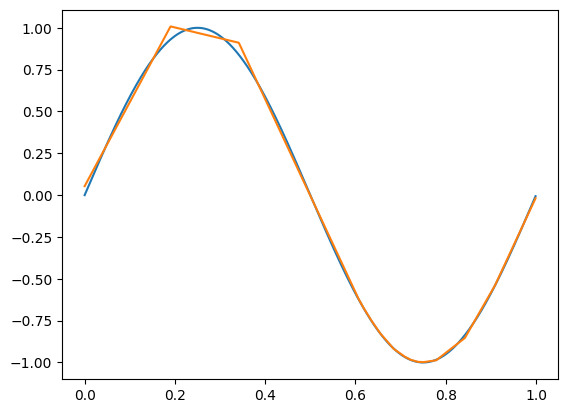

In [120]:
X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation2.output)
plt.show()


The rectified linear activation function and how its nonlinear behavior allowed us to map nonlinear functions, but we also need two or more hidden layer. In this case, we have only 1 hidden layer followed by the output layer. As we should know by now, this is simply not enough!

In [121]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_fn = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_precision = np.std(y) / 250

for epoch in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    data_loss = loss_fn.calculate(activation3.output, y)

    regularization_loss = \
        loss_fn.regularization_loss(dense1) + \
        loss_fn.regularization_loss(dense2) + \
        loss_fn.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < \
                       accuracy_precision)

    if not epoch % 100:
        print(f"epoch: {epoch}, " +
              f"acc: {accuracy:.3f}, " +
              f"loss: {loss:.3f} ("
              f"data_loss: {data_loss:.3f}, " +
              f"reg_loss: {regularization_loss:.3f}), " +
              f"lr: {optimizer.current_learning_rate}")

    loss_fn.backward(activation3.output, y)
    activation3.backward(loss_fn.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.002, loss: 4.478 (data_loss: 4.478, reg_loss: 0.000), lr: 0.001
epoch: 100, acc: 0.007, loss: 0.138 (data_loss: 0.138, reg_loss: 0.000), lr: 0.001
epoch: 200, acc: 0.018, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 300, acc: 0.028, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 400, acc: 0.035, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 500, acc: 0.037, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 600, acc: 0.047, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 700, acc: 0.050, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 800, acc: 0.074, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 900, acc: 0.085, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 1000, acc: 0.090, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoch: 1100, acc: 0.097, loss: 0.137 (data_loss: 0.137, reg_loss: 0.000), lr: 0.001
epoc

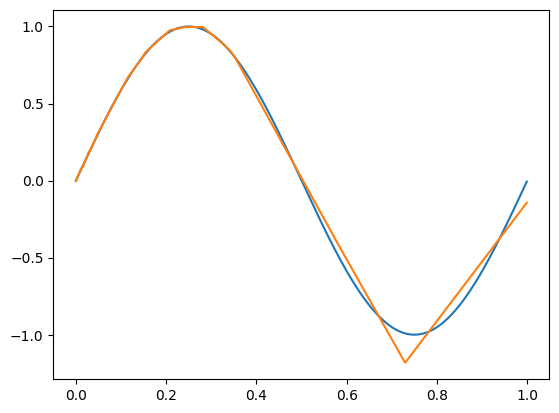

In [122]:
X_test, y_test = sine_data()

dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()


The model's accuracy is not very good, and loss seems stuck at a local minimum. We can help the model with being stuck at a local minimum by using a higher learning rate and add a learning rate decay.

In [123]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_fn = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate=0.01,
                           decay=1e-3)

accuracy_precision = np.std(y) / 250

for epoch in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    data_loss = loss_fn.calculate(activation3.output, y)

    regularization_loss = \
        loss_fn.regularization_loss(dense1) + \
        loss_fn.regularization_loss(dense2) + \
        loss_fn.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < \
                       accuracy_precision)

    if not epoch % 100:
        print(f"epoch: {epoch}, " +
              f"acc: {accuracy:.3f}, " +
              f"loss: {loss:.3f} ("
              f"data_loss: {data_loss:.3f}, " +
              f"reg_loss: {regularization_loss:.3f}), " +
              f"lr: {optimizer.current_learning_rate}")

    loss_fn.backward(activation3.output, y)
    activation3.backward(loss_fn.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.001, loss: 813.271 (data_loss: 813.271, reg_loss: 0.000), lr: 0.01
epoch: 100, acc: 0.010, loss: 0.086 (data_loss: 0.086, reg_loss: 0.000), lr: 0.009099181073703368
epoch: 200, acc: 0.017, loss: 0.055 (data_loss: 0.055, reg_loss: 0.000), lr: 0.008340283569641367
epoch: 300, acc: 0.017, loss: 0.040 (data_loss: 0.040, reg_loss: 0.000), lr: 0.007698229407236336
epoch: 400, acc: 0.027, loss: 0.027 (data_loss: 0.027, reg_loss: 0.000), lr: 0.007147962830593281
epoch: 500, acc: 0.026, loss: 0.020 (data_loss: 0.020, reg_loss: 0.000), lr: 0.0066711140760507
epoch: 600, acc: 0.044, loss: 0.016 (data_loss: 0.016, reg_loss: 0.000), lr: 0.006253908692933083
epoch: 700, acc: 0.071, loss: 0.012 (data_loss: 0.012, reg_loss: 0.000), lr: 0.005885815185403178
epoch: 800, acc: 0.095, loss: 0.010 (data_loss: 0.010, reg_loss: 0.000), lr: 0.005558643690939411
epoch: 900, acc: 0.089, loss: 0.008 (data_loss: 0.008, reg_loss: 0.000), lr: 0.0052659294365455505
epoch: 1000, acc: 0.094, loss: 0.00

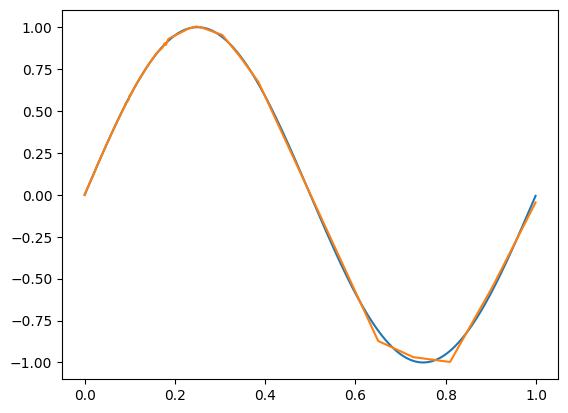

In [124]:
X_test, y_test = sine_data()

dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()


In [157]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_fn = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate=0.005,
                           decay=1e-3)

accuracy_precision = np.std(y) / 250

for epoch in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    data_loss = loss_fn.calculate(activation3.output, y)

    regularization_loss = \
        loss_fn.regularization_loss(dense1) + \
        loss_fn.regularization_loss(dense2) + \
        loss_fn.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < \
                       accuracy_precision)

    if not epoch % 100:
        print(f"epoch: {epoch}, " +
              f"acc: {accuracy:}, " +
              f"loss: {loss:} ("
              f"data_loss: {data_loss:}, " +
              f"reg_loss: {regularization_loss:}), " +
              f"lr: {optimizer.current_learning_rate}")

    loss_fn.backward(activation3.output, y)
    activation3.backward(loss_fn.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.002, loss: 0.508465592627499 (data_loss: 0.508465592627499, reg_loss: 0), lr: 0.005
epoch: 100, acc: 0.015, loss: 0.051725075629017785 (data_loss: 0.051725075629017785, reg_loss: 0), lr: 0.004549590536851684
epoch: 200, acc: 0.153, loss: 0.000996901290077903 (data_loss: 0.000996901290077903, reg_loss: 0), lr: 0.004170141784820684
epoch: 300, acc: 0.318, loss: 7.65256786161478e-05 (data_loss: 7.65256786161478e-05, reg_loss: 0), lr: 0.003849114703618168
epoch: 400, acc: 0.71, loss: 2.6705752536904295e-05 (data_loss: 2.6705752536904295e-05, reg_loss: 0), lr: 0.0035739814152966403
epoch: 500, acc: 0.713, loss: 1.7901819642310207e-05 (data_loss: 1.7901819642310207e-05, reg_loss: 0), lr: 0.00333555703802535
epoch: 600, acc: 0.718, loss: 1.4974079168566437e-05 (data_loss: 1.4974079168566437e-05, reg_loss: 0), lr: 0.0031269543464665416
epoch: 700, acc: 0.745, loss: 1.307854744423267e-05 (data_loss: 1.307854744423267e-05, reg_loss: 0), lr: 0.002942907592701589
epoch: 800, acc: 

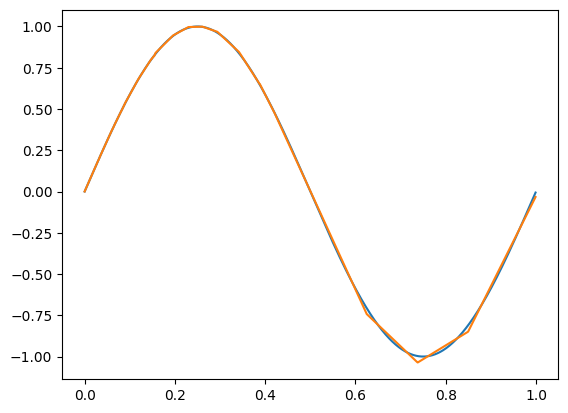

In [126]:
X_test, y_test = sine_data()

dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()


In [156]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()

loss_fn = Loss_MeanSquaredError()

optimizer = Optimizer_Adam(learning_rate=0.002,
                           decay=5e-3)

accuracy_precision = np.std(y) / 250

for epoch in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    data_loss = loss_fn.calculate(activation3.output, y)

    regularization_loss = \
        loss_fn.regularization_loss(dense1) + \
        loss_fn.regularization_loss(dense2) + \
        loss_fn.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < \
                       accuracy_precision)

    if not epoch % 100:
        print(f"epoch: {epoch}, " +
              f"acc: {accuracy:}, " +
              f"loss: {loss:} ("
              f"data_loss: {data_loss:}, " +
              f"reg_loss: {regularization_loss:.3f}), " +
              f"lr: {optimizer.current_learning_rate}")

    loss_fn.backward(activation3.output, y)
    activation3.backward(loss_fn.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.002, loss: 0.5079258422687111 (data_loss: 0.5079258422687111, reg_loss: 0.000), lr: 0.002
epoch: 100, acc: 0.005, loss: 0.1023804853679536 (data_loss: 0.1023804853679536, reg_loss: 0.000), lr: 0.0013377926421404682
epoch: 200, acc: 0.014, loss: 0.05735168766800878 (data_loss: 0.05735168766800878, reg_loss: 0.000), lr: 0.0010025062656641604
epoch: 300, acc: 0.096, loss: 0.040711712946975225 (data_loss: 0.040711712946975225, reg_loss: 0.000), lr: 0.0008016032064128255
epoch: 400, acc: 0.141, loss: 0.03087696853546328 (data_loss: 0.03087696853546328, reg_loss: 0.000), lr: 0.000667779632721202
epoch: 500, acc: 0.206, loss: 0.021378981396751203 (data_loss: 0.021378981396751203, reg_loss: 0.000), lr: 0.0005722460658082975
epoch: 600, acc: 0.219, loss: 0.012700112605418637 (data_loss: 0.012700112605418637, reg_loss: 0.000), lr: 0.0005006257822277848
epoch: 700, acc: 0.278, loss: 0.006713486109971154 (data_loss: 0.006713486109971154, reg_loss: 0.000), lr: 0.0004449388209121245

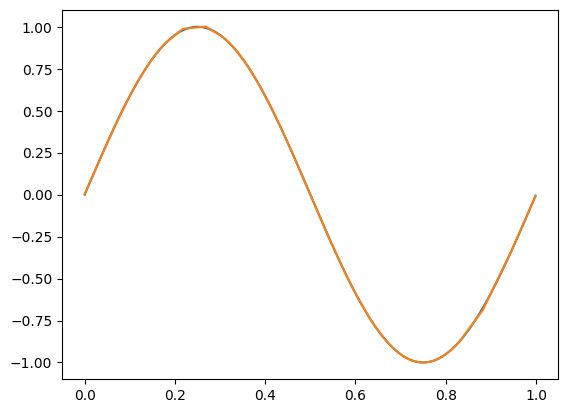

In [158]:
X_test, y_test = sine_data()

dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()


This model has now learned pretty well, but the curiosu part is that both lower and higer learning rates than what we used here initially caused accuracy to be pretty low and loss be stuck at the same value when the learning rate in betwen them actually worked.

The accuracy and loss suggest that updates to the parameters are not big enough, but the rising learning rate makes things only worse, and there is just this single spot that we were able to find that lets our model learn. It is import to initialize parameter intialization methods wisely. Turn out in the current case we can help the model learn by changing the factor of 0.01 to 0.1 in the Dense layer's weight initialization. Because the back-propagated gradient is calculated using weights, and the learning rate does not affect it. That's why it's important to use right weight initialization, and so far, we have been using the same values for each model.

This model was previously stuck and has now achieved high accuracy. As we can see, this time, our model learned in all cases, using different learning rates, and did not get stuck if any of them. That’s how much changing weight initialization can impact the training
process